<a href="https://colab.research.google.com/github/markNZed/GPT-NeoX-Colab/blob/main/notebooks/shakespeare_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a tiny SLM on a corpus of Shakespeare
The intention of this notebook is to demonstrate a setup for experimenting with a tiny SLM.
The following tools are used:
* Colab (https://colab.research.google.com/) for notebook execution
* DagsHub (https://dagshub.com/) for project tracking
* MLFlow (https://mlflow.org/) for experiment tracking
* Hydra (https://hydra.cc/) for configuration management
* GPTNeoX (https://github.com/EleutherAI/gpt-neox) for model training
* Tensorboard (https://www.tensorflow.org/tensorboard) for experiment monitoring
* DVC (https://dvc.org/) for data management
* GitHub (https://github.com/) for code management
* Backblaze (https://backblaze.com/) for data storage

In [1]:
from datetime import datetime
print("Current Date and Time:", datetime.now())

Current Date and Time: 2024-11-26 07:25:16.627409


In [2]:
# We could modify these paths to "stub" behavior for test/dev
workspaceDir = "/content"
try:
  from google import colab
  gpt_neox_colabDir = f"{workspaceDir}/GPT-NeoX-Colab"
except:
  gpt_neox_colabDir = f"/workspace"
GPTNeoXDirName = "gpt-neox"
GPTNeoXDir = f"{workspaceDir}/{GPTNeoXDirName}"

# Cloning Git Repos

In [3]:
%%time
#@title Clone GPT-NeoX-Colab
%cd {workspaceDir}
try:
    from google import colab
    # Don't use --depth 1 because that does not play nice with git-annex
    !git clone --depth 1 https://github.com/markNZed/GPT-NeoX-Colab.git
except:
    pass

/content
CPU times: user 861 μs, sys: 1.94 ms, total: 2.8 ms
Wall time: 2.06 ms


/workspace/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
%%time
import sys
%cd {gpt_neox_colabDir}
%pip install -q python-dotenv
from dotenv import load_dotenv
import os
load_dotenv()

USE_MY_ENV = False
if USE_MY_ENV:
  # Disabling pydevd_plugins so we do not get a restart warning
  if "pydevd_plugins" in sys.modules:
    del sys.modules["pydevd_plugins"]
  %pip install -q dvc[s3]
  if not os.path.isfile("my_env.tar.gz"):
    !dvc --quiet pull my_env.tar.gz
    !tar -xf my_env.tar.gz
  activate_script = f"{gpt_neox_colabDir}/my_env/bin/activate" 
else:
  try:
    from google import colab
    # Don't use --depth 1 because that does not play nice with git-annex
    !sudo apt-get update && sudo apt-get install -y python3.10-venv
    !pip install -q virtualenv
    !python3 -m venv my_env
    activate_script = f"{gpt_neox_colabDir}/my_env/bin/activate" 
    !source {activate_script} && pip install -q -r requirements_colab.txt
    !source {activate_script} && pip install -q .
  except:
    activate_script = f"{gpt_neox_colabDir}/.venv/bin/activate"
    !pip install -q dvc[s3]


/workspace
Note: you may need to restart the kernel to use updated packages.
CPU times: user 85 ms, sys: 15.2 ms, total: 100 ms
Wall time: 3.37 s


In [5]:
#@title Fetch training data
%cd {gpt_neox_colabDir}
!dvc --quiet pull "data/shakespeare/shakespeare.txt"

/workspace
Fetching
!
  0% Checking cache in '/workspace/.dvc/cache/files/md5'| |0/? [00:00<?,    ?fil
Fetching                                                                        
Building workspace index                              |3.00 [00:00,  433entry/s]
Comparing indexes                                    |4.00 [00:00, 1.11kentry/s]
Applying changes                                      |0.00 [00:00,     ?file/s]
Everything is up to date.


In [6]:
#@title Fetch processed training data
%cd {gpt_neox_colabDir}
!dvc --quiet pull "data/shakespeare/shakespeare.jsonl"
!dvc --quiet pull "data/shakespeare/shakespeare_text_document.bin"
!dvc --quiet pull "data/shakespeare/shakespeare_text_document.idx"

/workspace
Fetching
!
  0% Checking cache in '/workspace/.dvc/cache/files/md5'| |0/? [00:00<?,    ?fil
Fetching                                                                        
Building workspace index                              |3.00 [00:00,  245entry/s]
Comparing indexes                                    |4.00 [00:00, 1.57kentry/s]
Applying changes                                      |0.00 [00:00,     ?file/s]
Everything is up to date.
Fetching
!
  0% Checking cache in '/workspace/.dvc/cache/files/md5'| |0/? [00:00<?,    ?fil
Fetching                                                                        
Building workspace index                              |3.00 [00:00,  339entry/s]
Comparing indexes                                    |4.00 [00:00, 1.87kentry/s]
Applying changes                                      |0.00 [00:00,     ?file/s]
Everything is up to date.
Fetching
!
  0% Checking cache in '/workspace/.dvc/cache/files/md5'| |0/? [00:00<?,    ?fil
Fetching     

In [7]:
%%time
#@title Clone GPT-NeoX
%cd {workspaceDir}
#!git clone ---depth 1 https://github.com/EleutherAI/gpt-neox
!git clone -b pipe_parallel_size_1 --depth 1 https://github.com/markNZed/gpt-neox.git

/content
Cloning into 'gpt-neox'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 296 (delta 74), reused 137 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (296/296), 2.50 MiB | 2.52 MiB/s, done.
Resolving deltas: 100% (74/74), done.
CPU times: user 37.3 ms, sys: 10.3 ms, total: 47.7 ms
Wall time: 1.76 s


# Python Environment
It is faster to download a Python virtual environment and unzip it than to install all the dependencies.

In [8]:
if not USE_MY_ENV:
    # Could not redirect to /dev/null in the standard Colab notebook (maybe no output for a particular time?)
    # Currently deepspeed from GTP-NeoX is not compatible with logging in torch >= 2.4
    !bash -c "source {activate_script}" && pip install -q torch==2.3 torchaudio==2.3.0 torchvision==0.18.0 transformers==4.38.0 sentence-transformers==2.2.2
    %cd {GPTNeoXDir}
    !bash -c "source {activate_script}" && pip install -q -r ./requirements/requirements.txt
    !bash -c "source {activate_script}" && pip install -q -r ./requirements/requirements-tensorboard.txt

/content/gpt-neox
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2024.10.0 requires fsspec==2024.10.0.*, but you have fsspec 2024.9.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.13.0 which is incompatible.


# Preparing Custom Dataset

In [9]:
#@title Converting text data to jsonl format
import os

%cd {GPTNeoXDir}
!mkdir -p data

# Check if the converted file exists
if not os.path.isfile(f"{gpt_neox_colabDir}/data/shakespeare/shakespeare.jsonl"):
    gpt_neox_colab.utils.ml.text2jsonl(f"{gpt_neox_colabDir}/data/shakespeare/shakespeare.txt", f"{gpt_neox_colabDir}/data/shakespeare/shakespeare.jsonl")

!cp {gpt_neox_colabDir}/data/shakespeare/shakespeare.jsonl {GPTNeoXDir}/data/shakespeare.jsonl

/content/gpt-neox


# Tokenizing Dataset

In [10]:
%%time
#@title Tokenizing jsonl formatted data
import os

%cd {GPTNeoXDir}
!mkdir -p processed_data

# Check if the tokenized files exists
a = f"{gpt_neox_colabDir}/data/shakespeare/shakespeare_text_document.idx"
b = f"{gpt_neox_colabDir}/data/shakespeare/shakespeare_text_document.bin"
if not os.path.isfile(a) or not os.path.isfile(b):
    !bash -c "source {activate_script}" && python tools/datasets/preprocess_data.py \
        --input ./data/shakespeare.jsonl \
        --output-prefix ./processed_data \
        --tokenizer-type CharLevelTokenizer \
        --dataset-impl mmap \
        --append-eod
    !cp {GPTNeoXDir}/processed_data/shakespeare_text_document.bin {gpt_neox_colabDir}/data/shakespeare
    !cp {GPTNeoXDir}/processed_data/shakespeare_text_document.idx {gpt_neox_colabDir}/data/shakespeare

!cp {gpt_neox_colabDir}/data/shakespeare/shakespeare_text_document.bin {GPTNeoXDir}/processed_data
!cp {gpt_neox_colabDir}/data/shakespeare/shakespeare_text_document.idx {GPTNeoXDir}/processed_data

/content/gpt-neox
CPU times: user 5.64 ms, sys: 12.5 ms, total: 18.2 ms
Wall time: 337 ms


# Training

In [11]:
%load_ext tensorboard

In [12]:
import subprocess
# Start a detached background process using the temp config
cmd = f"""nohup bash -c "source {activate_script} && \
cd {GPTNeoXDir} && \
python ./deepy.py train.py --conf_dir {gpt_neox_colabDir}/configs shakespeare shakespeare_deepy" """
print("Running command:", cmd)
#cmd = "nohup bash -c ls" # Used to test without running on GPU

# Start the process and retrieve the PID directly
process = subprocess.Popen(
    cmd,
    shell=True,
    executable='/bin/bash',
    preexec_fn=os.setsid  # Starts the process in a new session
)

pid = process.pid
print(f"Started training with PID: {pid}")

Running command: nohup bash -c "source /workspace/.venv/bin/activate && cd /content/gpt-neox && python ./deepy.py train.py --conf_dir /workspace/configs shakespeare shakespeare_deepy" 
Started training with PID: 84635


In [13]:
#@title Wait until tensorboard log directory is created
import time
import os

# Path to the TensorBoard log directory
tensorboard_log_dir = f"{GPTNeoXDir}/tensorboard"

# Wait for the directory to be created
while not os.path.exists(tensorboard_log_dir):
    print("Waiting for TensorBoard log directory to be created...")
    time.sleep(10)  # Check every X seconds

print("TensorBoard log directory found. You can now launch TensorBoard.")

Waiting for TensorBoard log directory to be created...
[2024-11-26 07:28:54,134] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/content/gpt-neox/megatron/neox_arguments/arguments.py:1101: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
/content/gpt-neox/megatron/neox_arguments/arguments.py:1110: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


NeoXArgs.from_ymls() ['/workspace/configs/shakespeare.yml', '/workspace/configs/shakespeare_deepy.yml']
-------------------- arguments --------------------
  attention_config ................ ['global', 'global', 'global', 'global']updated
  batch_size ...................... 256.........................updated
  checkpoint_factor ............... 50..........................updated
  config_files .................... {'shakespeare.yml': '{\n  "pipe_parallel_size": 0, # Because running on one GPU\n  "model_parallel_size": 1, # Because running on one GPU\n\n  # model settings\n  "num_layers": 4,\n  "hidden_size": 256,\n  "num_attention_heads": 4,\n  "seq_length": 512,\n  "max_position_embeddings": 512,\n  "pos_emb": "rotary",\n  "no_weight_tying": false, # Sharing embedding and output weights\n  "gpt_j_residual": false,\n  "output_layer_parallelism": "column",\n\n  "scaled_upper_triang_masked_softmax_fusion": false,\n  "bias_gelu_fusion": false,\n  "rope_fusion": false,\n  "layernorm_fusi

INFO:root:NeoXArgs.calculate_derived() Total number of GPUs determined to be: 1


[2024-11-26 07:29:00,527] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Waiting for TensorBoard log directory to be created...
[2024-11-26 07:29:04,201] [INFO] [launch.py:145:main] WORLD INFO DICT: {'localhost': [0]}
[2024-11-26 07:29:04,201] [INFO] [launch.py:151:main] nnodes=1, num_local_procs=1, node_rank=0
[2024-11-26 07:29:04,201] [INFO] [launch.py:162:main] global_rank_mapping=defaultdict(<class 'list'>, {'localhost': [0]})
[2024-11-26 07:29:04,201] [INFO] [launch.py:163:main] dist_world_size=1
[2024-11-26 07:29:04,201] [INFO] [launch.py:165:main] Setting CUDA_VISIBLE_DEVICES=0


/content/gpt-neox/megatron/neox_arguments/arguments.py:1101: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
/content/gpt-neox/megatron/neox_arguments/arguments.py:1110: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


[2024-11-26 07:29:06,009] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Unable to import Mamba kernels. Install them from our requirements/requirements-mamba.txt,     or directly from https://github.com/state-spaces/mamba
For s3 checkpointing, please install hf_transfer either using requirements/requirements-s3.txt or https://github.com/huggingface/hf_transfer
NeoXArgs.configure_distributed_args() using world size: 1 and model-parallel size: 1 
> building CharLevelTokenizer tokenizer ...
 > padded vocab (size: 512) with 0 dummy tokens (new size: 512)


2024-11-26 07:29:10.599623: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 07:29:10.739563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732606150.797508   84775 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732606150.814905   84775 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 07:29:10.949711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Waiting for TensorBoard log directory to be created...
> setting up tensorboard ...
> initializing torch distributed ...
[2024-11-26 07:29:15,287] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-11-26 07:29:15,287] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
> initializing model parallel with size 1
MPU DP: [0]
MPU PP: [0]
MPU MP: [0]
> setting random seeds to 1234 ...
[2024-11-26 07:29:15,292] [INFO] [checkpointing.py:227:model_parallel_cuda_manual_seed] > initializing model parallel cuda seeds on global rank 0, model parallel rank 0, and data parallel rank 0 with model parallel seed: 3952 and data parallel seed: 1234
make: Entering directory '/content/gpt-neox/megatron/data'
g++ -O3 -Wall -shared -std=c++11 -fPIC -fdiagnostics-color -I/usr/include/python3.10 -I/workspace/.venv/lib/python3.10/site-packages/pybind11/include helpers.cpp -o helpers.cpython-310-x86_64-linux-gnu.so
make: Leaving directory '/content/gpt-neox/megatron/d

/content/gpt-neox/megatron/data/gpt2_dataset.py:373: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  counts = torch.cuda.LongTensor([1])


 > loading doc-idx mapping from processed_data/shakespeare_text_document_train_indexmap_204800ns_512sl_1234s_packedpi_ac_doc_idx.npy
 > loading sample-idx mapping from processed_data/shakespeare_text_document_train_indexmap_204800ns_512sl_1234s_packedpi_ac_sample_idx.npy
 > loading shuffle-idx mapping from processed_data/shakespeare_text_document_train_indexmap_204800ns_512sl_1234s_packedpi_ac_shuffle_idx.npy
    loaded indexed file in 0.001 seconds
    total number of samples: 206363
    total number of epochs: 98
 > WARNING: could not find index map files, building the indices on rank 0 ...
 > elapsed time to build and save doc-idx mapping (seconds): 0.005150
    using:
     number of documents:       983
     number of epochs:          244
     sequence length:           512
     total number of samples:   13867
 > elapsed time to build and save sample-idx mapping (seconds): 0.000437
 > elapsed time to build and save shuffle-idx mapping (seconds): 0.000341
 > loading doc-idx mapping

Using /home/vscode/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /home/vscode/.cache/torch_extensions/py310_cu121/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/vscode/.cache/torch_extensions/py310_cu121/fused_adam/build.ninja...
/workspace/.venv/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


TensorBoard log directory found. You can now launch TensorBoard.


In [18]:
# Need to delete everything in checkpoints and tensorboard dir for a fresh run
%cd {GPTNeoXDir}
%tensorboard --logdir tensorboard

/content/gpt-neox


/workspace/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Reusing TensorBoard on port 6006 (pid 84977), started 0:09:03 ago. (Use '!kill 84977' to kill it.)

In [19]:
#@title Find the latest log file
import glob
import os

# Define the log directory and pattern for log files
log_dir = f"{GPTNeoXDir}/logs"
log_pattern = os.path.join(log_dir, "*_stdout.txt")

# Get the list of log files that match the pattern
log_files = glob.glob(log_pattern)

# Ensure there are log files in the directory
if log_files:
    # Find the latest log file based on modification time
    latest_log = max(log_files, key=os.path.getmtime)
    print("Latest log file:", latest_log)
else:
    latest_log = None
    print("No log files found.")


Latest log file: /content/gpt-neox/logs/51703d75a264_stdout.txt


In [20]:
#@title Read the latest log file and extract the iteration count
import time
import os
import re

# File to store the last read position (persistence between script runs)
file_position = 0
# Regular expression to match "iteration <number> / <total>"
iteration_pattern = re.compile(r"iteration\s+(\d+)\s*/\s*\d+")

def read_new_iterations():
    global file_position
    # Open the log file and seek to the last position
    with open(latest_log, "r") as file:
        file.seek(file_position)
        # Read new lines
        new_lines = file.readlines()
        file_position = file.tell()
        # Process lines containing "iteration"
        last_match = None
        for line in new_lines:
            match = iteration_pattern.search(line)
            if match:
                last_match = match
        if last_match:
            # Extract the iteration count from the regex match
            iteration_count = int(last_match.group(1))
            print(f"{iteration_count} iterations")

# Periodically check if the process has completed
while True:
    # Poll the process to see if it has terminated
    if process.poll() is not None:
        # Process has completed
        print("Training has completed.")
        break
    else:
        if latest_log:
            read_new_iterations()
        elif os.path.exists(f"{experimentDir}/logs"):
            latest_log = get_latest_file(f"{experimentDir}/logs", "*_stdout.txt")
        print("Training is still running...")
        time.sleep(30)  # Check every X seconds

print("Training has finished.")


Training has completed.
Training has finished.


Available scalar keys: ['timers/forward', 'timers/backward', 'timers/backward-backward', 'timers/backward-allreduce', 'timers/optimizer', 'timers/batch generator', 'train/learning_rate', 'train/lm_loss', 'train/loss_scale', 'runtime/samples_per_sec', 'runtime/iteration_time', 'runtime/flops_per_sec_per_gpu', 'validation/lm_loss', 'validation/lm_loss_ppl', 'test/lm_loss', 'test/lm_loss_ppl']


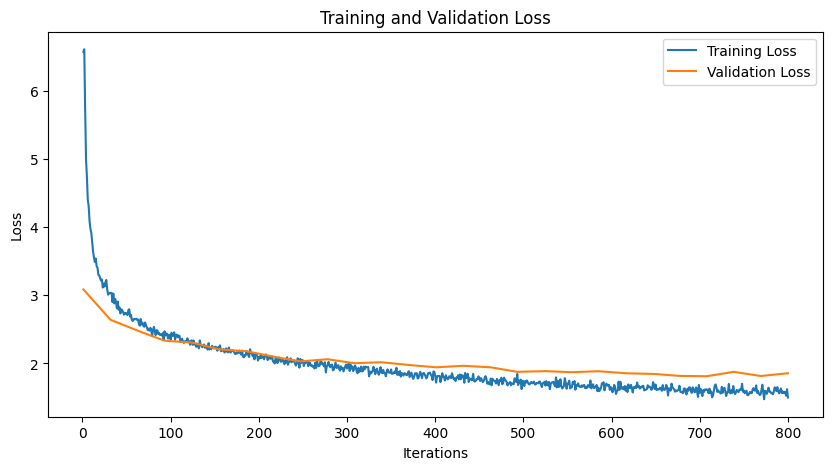

In [21]:
#@title Display training and validation Loss
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import os
import numpy as np
# Path to the latest log file
log_dir = "tensorboard"
log_files = [os.path.join(log_dir, d) for d in os.listdir(log_dir)]
latest_log_dir = max(log_files, key=os.path.getmtime)

# Initialize EventAccumulator to load scalar data
ea = event_accumulator.EventAccumulator(latest_log_dir)
ea.Reload()  # Load all logs

# List all scalar keys available in the logs
scalar_keys = ea.Tags()['scalars']
print("Available scalar keys:", scalar_keys)

# Extract training and validation losses
train_loss = ea.Scalars('train/lm_loss')  # Adjust for actual name if necessary
val_loss = ea.Scalars('validation/lm_loss')  # Adjust for actual name if necessary

# Convert to lists for plotting
train_loss_values = [x.value for x in train_loss]
val_loss_values = [x.value for x in val_loss]

# Find the lengths of both arrays
len_train = len(train_loss_values)
len_val = len(val_loss_values)

iterations = None
# Interpolate the shorter array
if len_train != len_val:
    if len_train > len_val:
        # Interpolate validation loss to match the training loss length
        iterations = np.linspace(1, len_train, len_train)
        val_iterations = np.linspace(1, len_train, len_val)
        val_loss_values = np.interp(iterations, val_iterations, val_loss_values)
    else:
        # Interpolate training loss to match the validation loss length
        iterations = np.linspace(1, len_val, len_val)
        train_iterations = np.linspace(1, len_val, len_train)
        train_loss_values = np.interp(iterations, train_iterations, train_loss_values)
else:
    iterations = range(1, len_train + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss_values, label='Training Loss')
plt.plot(iterations, val_loss_values, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Inference with GPT-NeoX

In [22]:
%%time
%cd {GPTNeoXDir}
# This has issues if used during training -  The server socket has failed to bind to [::]:29500 (errno: 98 - Address already
# This will write over the logs
!bash -c "source {activate_script}" && python ./deepy.py generate.py -d configs {gpt_neox_colabDir}/configs/shakespeare {gpt_neox_colabDir}/configs/shakespeare_gen
!cat sample_output.txt

/content/gpt-neox
[2024-11-26 07:39:05,362] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/content/gpt-neox/megatron/neox_arguments/arguments.py:1101: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
/content/gpt-neox/megatron/neox_arguments/arguments.py:1110: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
NeoXArgs.from_ymls() ['/workspace/configs/shakespeare.yml', '/workspace/configs/shakespeare_gen.yml']
INFO:root:NeoXArgs.calculate_derived() Total number of GPUs determined to be: 1
-------------------- arguments --------------------
  attention_config ................ ['global', 'global', 'global', 'global']updated
  batch_size ...................... 8...........................updated
  checkpoint_factor ............... 50..........................updated
  config_files .................... {'shakespeare.yml': '{\n  "pipe_parallel_size": 0, # Because running on one GPU\n 

In [23]:
# 2.21.0 was the last 2 series but it asks for trust_remote_code
!bash -c "source {activate_script}" &&  pip install datasets==2.14.6

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
  Attempting uninstall: datasets
    Found existing installation: datasets 3.1.0
    Uninstalling datasets-3.1.0:
      Successfully uninstalled datasets-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dvc 3.56.0 requires fsspec>=2

In [24]:
%%time
# This has issues if used during training -  The server socket has failed to bind to [::]:29500 (errno: 98 - Address already
# This will write over the logs
# python ./deepy.py eval.py -d configs your_configs.yml --eval_tasks task1 task2 ... taskn
# NOTE this will prompt for permission to run a download script - would need an older datasetse library to avoid this
%cd {GPTNeoXDir}
!bash -c "source {activate_script}" && python ./deepy.py eval.py -d configs {gpt_neox_colabDir}/configs/shakespeare {gpt_neox_colabDir}/configs/shakespeare_gen --eval_tasks hellaswag
!cat sample_output.txt

/content/gpt-neox
[2024-11-26 07:39:56,065] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
/content/gpt-neox/megatron/neox_arguments/arguments.py:1101: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
/content/gpt-neox/megatron/neox_arguments/arguments.py:1110: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
NeoXArgs.from_ymls() ['/workspace/configs/shakespeare.yml', '/workspace/configs/shakespeare_gen.yml']
INFO:root:NeoXArgs.calculate_derived() Total number of GPUs determined to be: 1
-------------------- arguments --------------------
  attention_config ................ ['global', 'global', 'global', 'global']updated
  batch_size ...................... 8...........................updated
  checkpoint_factor ............... 50..........................updated
  config_files .................... {'shakespeare.yml': '{\n  "pipe_parallel_size": 0, # Because running on one GPU\n 

# Inference with Hugging Face

## Convert model to HF format
Here we are converting our model to `HuggingFace Format`.

In [25]:
import os

# Define the path to the checkpoints directory
checkpoints_dir = f"{GPTNeoXDir}/checkpoints"

# Read the 'latest' file to get the latest checkpoint name
with open(os.path.join(checkpoints_dir, "latest"), "r") as f:
    latest_checkpoint_name = f.read().strip()

# Construct the full path to the latest checkpoint directory
latest_checkpoint_path = os.path.join(checkpoints_dir, latest_checkpoint_name)
print("Path to the latest checkpoint:", latest_checkpoint_path)


Path to the latest checkpoint: /content/gpt-neox/checkpoints/global_step800


In [26]:
#@title Convert last checkpoint to huggingface model
%cd {GPTNeoXDir}
!bash -c "source {activate_script}" && python ./tools/ckpts/convert_neox_to_hf.py --input_dir {latest_checkpoint_path} --config_file {gpt_neox_colabDir}/configs/shakespeare.yml --output_dir {gpt_neox_colabDir}/data/shakespeare --architecture neox

/content/gpt-neox
/content/gpt-neox/megatron/neox_arguments/arguments.py:1101: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
/content/gpt-neox/megatron/neox_arguments/arguments.py:1110: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
[2024-11-26 07:41:22,688] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Detected 'pipe-parallel-size' of 0, assuming model is saved as Sequential...
> building CharLevelTokenizer tokenizer ...
 > padded vocab (size: 512) with 0 dummy tokens (new size: 512)
Auto-detecting precision to save model into...
Saving weights in fp16 precision...
Detected MLP naming convention: new
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 273.32it/s]


## Generate Text

In [27]:
import sys
sys.path.insert(0, f"{gpt_neox_colabDir}/my_env/lib/python3.10/site-packages")

from transformers import GPTNeoXForCausalLM
import torch

# Move to model directory
%cd {gpt_neox_colabDir}

# Assuming CharLevelTokenizer is properly imported and instantiated
from gpt_neox_colab import CharLevelTokenizer
tokenizer = CharLevelTokenizer.CharLevelTokenizer(vocab_size=512)

# Load your model
model_path = f"{gpt_neox_colabDir}/data/shakespeare"
model = GPTNeoXForCausalLM.from_pretrained(model_path)

# Define a simple char-level tokenizer if not provided
def char_level_tokenize(text):
    return tokenizer.tokenize(text)

def char_level_detokenize(tokens):
    return tokenizer.detokenize(tokens)

# Set the model to evaluation mode
model.eval()

# Prompt the user for input
#input_text = input("Enter your prompt: ")
input_text = "Thou art"

# Tokenize and prepare input
input_ids = torch.tensor([char_level_tokenize(input_text)], dtype=torch.long)
attention_mask = torch.ones_like(input_ids)  # Create an attention mask for non-padded input

# Generate text with specified pad_token_id and attention_mask
with torch.no_grad():
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=200,          # Adjust this for desired output length
        temperature=0.7,        # Controls creativity
        top_k=50,               # Controls diversity
        top_p=0.9,              # Nucleus sampling
        num_return_sequences=1, # Number of sequences to return
        pad_token_id=model.config.eos_token_id,  # Set pad_token_id explicitly
        do_sample=True           # Enable sampling mode to use temperature and top_p
    )

# Decode and print the generated text
generated_text = char_level_detokenize(output[0].tolist())
print("Generated text:", generated_text)

/workspace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/workspace
Generated text: Thou art that hath, and his reash hours, Is see the const of it. PERLINA: O the world me him in the doth, That me to the strates so do My brant the for the thee of him: Let Anger here to part, Or you 


In [ ]:
try:
    from google.colab import output
    import time
    while True:
        
        output.eval_js("new Audio(\"https://upload.wikimedia.org/wikipedia/commons/e/e6/Coins_dropped_in_metallic_moneybox_0.ogg\").play()")
        time.sleep(30)
except:
    # Too hard to get sound working in Docker with remote VSCode
    pass

In [ ]:

import IPython
# Autplay does not work in VSCode
IPython.display.Audio(filename="/workspace/notebooks/beep-01a.mp3", autoplay=True)

In [ ]:
import IPython
import numpy as np
fs = 16000.
# Autplay does not work in VSCode
IPython.display.Audio(np.sin(2*np.pi*440*np.arange(5 * fs)/fs), rate=fs, autoplay=True)

In [ ]:
# Here we could disconnect from the Colab GPU resource but we will lose all results
#from google.colab import runtime
#runtime.unassign()
